# More Advanced Techniques (and Architectures)
We have thus far studied a number of convolutional networks for performing classification, specifically using the Fashion MNIST dataset. However, as the classification problem becomes more complicated, it will require more complicated architectures and more involved methods for regularizing the data. For instance, object recognition requires more knowledge than simple handwriting digits (as in the case of recognizing shirts in Fashion MNIST). The complexities of the picture are more varied, color has an influence, and much more. Therefore, the simple convolutions that we used before might not be expressive enough without a number of additional layers. 

Let's try some of these techniques with Fashion MNIST data. Some of these concepts we have already talked about, such as different initializations and different regularizers. Namely, we will cover these concepts:

- Expansion
- Initialization
- Batch Normalization
- Ensembling
- Building Blocks from More Advanced Networks (bypass, branching, etc.)

After going through this tutorial, you will have an understanding of how to use some of the more advanced techniques--however we are limited here by the hardware and time in lecture. Many modern architectures can take days/weeks to train and are extremely deep (look at the 100+ layers of ResNet-112). However, some of the architectures from ~2013 and ~2014 are manageable to investigate and take only a few hours to train. We will cover a few concepts for getting models up and running, and maybe even use more some complicated architectures. Let's get started! 

This is also an excellent tutorial with even more information than I am showing for the fine tuning techniques:
- https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model

keras.__version__

'2.2.4-tf'

In [3]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(acc))
    
        

Now let's load in a more diverse, harder to classify dataset: Fashion MNIST
https://www.kaggle.com/zalando-research/fashionmnist

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In [4]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='fashion_t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

NUM_CLASSES = 10
img_wh = 28

# Let's start by fixing the sizes, channels last
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))

Rows: 60000, columns: 784
Rows: 10000, columns: 784
New Shape: Rows: 60000, image size: (28,28,1)


(60000, 28, 28, 1)


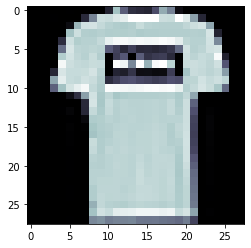

In [5]:
print(X_train.shape)
plt.subplot(1,1,1)
plt.imshow(X_train[1].squeeze(),cmap='bone')
plt.show()

## Starting simple
Let's first start by using data expansion on the Fashion MNIST dataset.

In [6]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

idx = 0

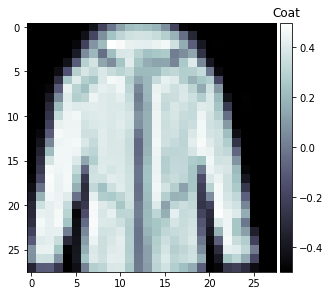

In [7]:
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
    plt.title(labels[np.argmax(tmp[1])])
    break

In [8]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )


Epoch 1/5
468/468 [==============================] - 208s 445ms/step - loss: 0.7796 - accuracy: 0.7149 - val_loss: 0.4587 - val_accuracy: 0.8314
Epoch 2/5
468/468 [==============================] - 203s 434ms/step - loss: 0.5466 - accuracy: 0.8007 - val_loss: 0.3776 - val_accuracy: 0.8623
Epoch 3/5
468/468 [==============================] - 197s 421ms/step - loss: 0.4819 - accuracy: 0.8267 - val_loss: 0.3412 - val_accuracy: 0.8799
Epoch 4/5
468/468 [==============================] - 200s 428ms/step - loss: 0.4521 - accuracy: 0.8391 - val_loss: 0.3357 - val_accuracy: 0.8779
Epoch 5/5
468/468 [==============================] - 200s 427ms/step - loss: 0.4312 - accuracy: 0.8473 - val_loss: 0.3100 - val_accuracy: 0.8874
CPU times: user 1h 14min 44s, sys: 29.4 s, total: 1h 15min 13s
Wall time: 16min 49s


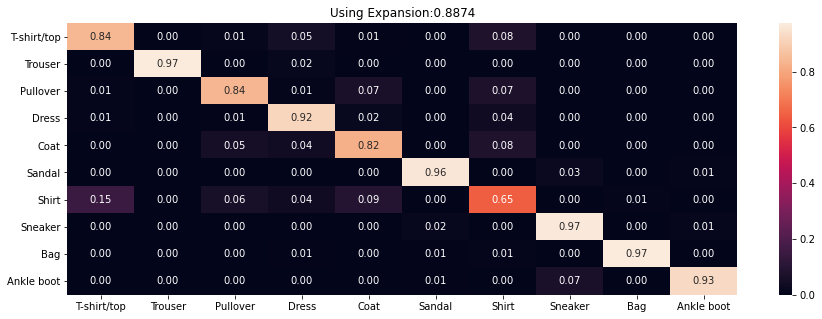

In [9]:
summarize_net(cnn, X_test, y_test, title_text='Using Expansion:')

In [11]:
# what if we just want to use the validation data??
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',
               data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=128,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last")) # more compact syntax

cnn.add(Conv2D(filters=128,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu',data_format="channels_last"))
    

# add one layer on flattened output

cnn.add(Flatten())
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=50, verbose=1,
                  validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/50
468/468 [==============================] - 297s 635ms/step - loss: 0.8621 - accuracy: 0.7249 - val_loss: 0.5601 - val_accuracy: 0.8299
Epoch 2/50
468/468 [==============================] - 296s 632ms/step - loss: 0.5665 - accuracy: 0.8365 - val_loss: 0.4695 - val_accuracy: 0.8718
Epoch 3/50
468/468 [==============================] - 313s 668ms/step - loss: 0.5077 - accuracy: 0.8593 - val_loss: 0.4272 - val_accuracy: 0.8878
Epoch 4/50
468/468 [==============================] - 358s 764ms/step - loss: 0.4738 - accuracy: 0.8715 - val_loss: 0.4196 - val_accuracy: 0.8912
Epoch 5/50
468/468 [==============================] - 371s 793ms/step - loss: 0.4492 - accuracy: 0.8804 - val_loss: 0.4103 - val_accuracy: 0.8929
Epoch 6/50
468/468 [==============================] - 373s 798ms/step - loss: 0.4324 - accuracy: 0.8873 - val_loss: 0.3670 - val_accuracy: 0.9080
Epoch 7/50
468/468 [==============================] - 372s 794ms/step - loss: 0.4189 - accuracy: 0.8922 - val_loss: 0.3889 -

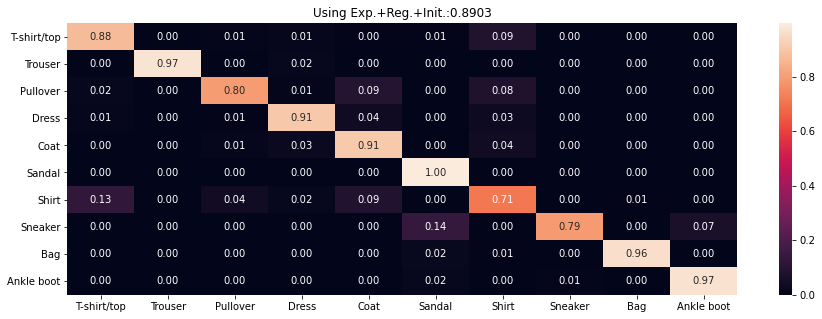

In [12]:
summarize_net(cnn, X_test, y_test, title_text='Using Exp.+Reg.+Init.:')

# Ensemble Nets
Now lets do the exact same thing, but with an average of three separate networks. 

To get this running, we are going to use the keras `Model API` which is different than the `Sequential API`. It requires that we explicitly define the inputs and outputs, and gives us a bit more control over the network topology.

- https://keras.io/models/model/

Reminder of Differences from Sequential and Functional APIs:
- You will need to specify the input and output nodes explicitly.
 - `input_layer = Input(shape=(**insert shape here**))`
- You no longer `add` to a `Sequential`, you feed layer by layer:
 - `model.add(Dense())` becomes `layer2 = Dense()(input_layer)`
 - subsequent layers use temporary variables like `layer1` and `input_layer` above
- Tell the Model what the input and output temporary variables are:
 - `model = Model(inputs=input_layer,outputs=layer1)`
 - then you can call `model.compile()`
- A great example that uses the Model API with MNIST:
 - https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [15]:
%%time

from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 32)   0           conv2d_9[0][0]                   
______________________________________________________________________________________________

In [16]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])



In [17]:
%%time
# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
468/468 [==============================] - 342s 730ms/step - loss: 0.9119 - accuracy: 0.6610 - val_loss: 0.5361 - val_accuracy: 0.7870
Epoch 2/50
468/468 [==============================] - 342s 731ms/step - loss: 0.5525 - accuracy: 0.7896 - val_loss: 0.4381 - val_accuracy: 0.8308
Epoch 3/50
468/468 [==============================] - 380s 812ms/step - loss: 0.4759 - accuracy: 0.8223 - val_loss: 0.3652 - val_accuracy: 0.8619
Epoch 4/50
468/468 [==============================] - 375s 802ms/step - loss: 0.4217 - accuracy: 0.8422 - val_loss: 0.3563 - val_accuracy: 0.8699
Epoch 5/50
468/468 [==============================] - 381s 814ms/step - loss: 0.3861 - accuracy: 0.8572 - val_loss: 0.3231 - val_accuracy: 0.8843
Epoch 6/50
468/468 [==============================] - 370s 790ms/step - loss: 0.3543 - accuracy: 0.8694 - val_loss: 0.2994 - val_accuracy: 0.8896
Epoch 7/50
468/468 [==============================] - 357s 764ms/step - loss: 0.3363 - accuracy: 0.8773 - val_loss: 0.2964 -

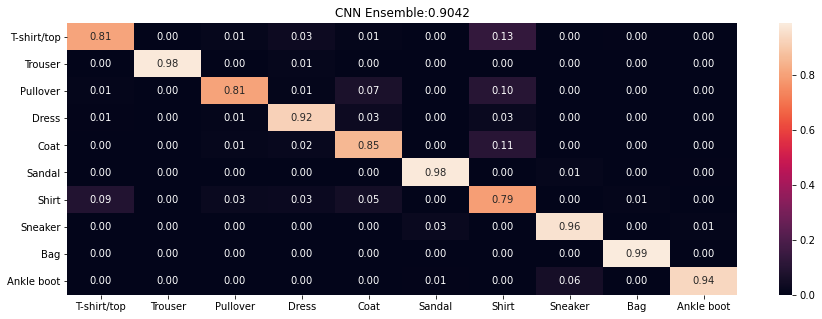

In [18]:
summarize_net(cnn_ens, X_test, y_test, title_text='CNN Ensemble:')

___
# Adding ResNet Style Blocks
Okay, so now lets try a trick from 2016---ancient in terms of deep learning years (that's a joke 🤷, ¯\\_(ツ)_/¯). 

The ResNet-Style Bypass is described in the following:
![resnet](https://cdn-images-1.medium.com/max/1600/0*0r0vS8myiqyOb79L.jpg)

In [21]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 14, 14, 32)   0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 14, 14, 32)   9248        max_pooling2d_10[0][0]           
____________________________________________________________________________________________

In [22]:
resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
# resnet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
#                       steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
#                       epochs=50, verbose=1,
#                       validation_data=(X_test,y_test_ohe),
#                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
#                      )

resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 20s 341us/sample - loss: 0.7022 - accuracy: 0.7458 - val_loss: 0.3966 - val_accuracy: 0.8520
Epoch 2/50
60000/60000 [==============================] - 20s 338us/sample - loss: 0.4224 - accuracy: 0.8456 - val_loss: 0.3564 - val_accuracy: 0.8677
Epoch 3/50
60000/60000 [==============================] - 21s 350us/sample - loss: 0.3619 - accuracy: 0.8674 - val_loss: 0.3062 - val_accuracy: 0.8858
Epoch 4/50
60000/60000 [==============================] - 21s 345us/sample - loss: 0.3277 - accuracy: 0.8809 - val_loss: 0.2875 - val_accuracy: 0.8940
Epoch 5/50
60000/60000 [==============================] - 20s 335us/sample - loss: 0.3057 - accuracy: 0.8898 - val_loss: 0.2741 - val_accuracy: 0.9004
Epoch 6/50
60000/60000 [==============================] - 20s 327us/sample - loss: 0.2863 - accuracy: 0.8960 - val_loss: 0.2691 - val_accuracy: 0.9010
Epoch 7/50
60000/60000 [====================

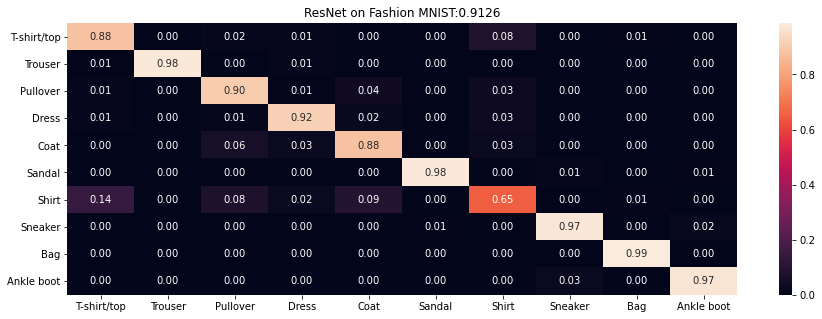

In [23]:
summarize_net(resnet, X_test, y_test, title_text='ResNet on Fashion MNIST:')

In [27]:
# Xception style architecture
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.000001



input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


x = Activation("relu")(x_split)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES,activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 14, 14, 32)   0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 14, 14, 32)   9248        max_pooling2d_13[0][0]           
____________________________________________________________________________________________

In [28]:
# speed up by training by not using augmentation, perhaps there are faster ways??
xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception.fit(X_train, y_train_ohe, batch_size=32,
            epochs=50, verbose=1,
            validation_data=(X_test,y_test_ohe),
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
            )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 24s 402us/sample - loss: 0.6121 - accuracy: 0.7750 - val_loss: 0.3892 - val_accuracy: 0.8573
Epoch 2/50
60000/60000 [==============================] - 24s 407us/sample - loss: 0.4081 - accuracy: 0.8497 - val_loss: 0.3341 - val_accuracy: 0.8746
Epoch 3/50
60000/60000 [==============================] - 25s 417us/sample - loss: 0.3598 - accuracy: 0.8676 - val_loss: 0.3188 - val_accuracy: 0.8817
Epoch 4/50
60000/60000 [==============================] - 25s 410us/sample - loss: 0.3302 - accuracy: 0.8788 - val_loss: 0.2903 - val_accuracy: 0.8908
Epoch 5/50
60000/60000 [==============================] - 24s 405us/sample - loss: 0.3101 - accuracy: 0.8874 - val_loss: 0.2878 - val_accuracy: 0.8950
Epoch 6/50
60000/60000 [==============================] - 25s 412us/sample - loss: 0.2982 - accuracy: 0.8908 - val_loss: 0.2702 - val_accuracy: 0.8992
Epoch 7/50
60000/60000 [====================

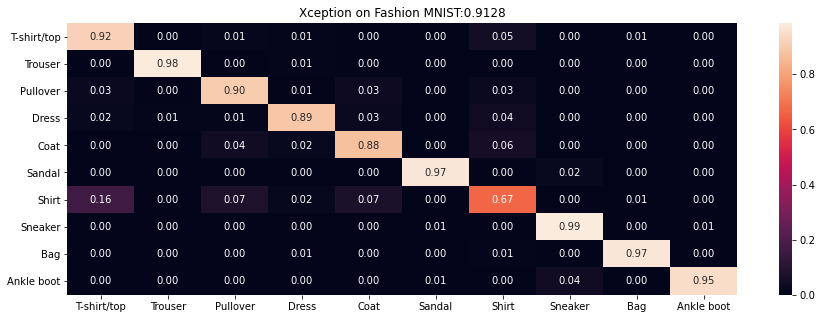

In [29]:
summarize_net(xception, X_test, y_test, title_text='Xception on Fashion MNIST:')

# Using Pre-trained Models
You also have fantastic access to different pre-trained models such as Xception, DenseNet, ResNest, VGG, and many other. For an updated key of available models see:
- https://keras.io/applications/

In [1]:
# workaround for multiple OpenMP on Mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%%time

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

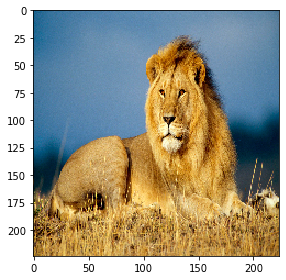

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.io import imshow

def get_image(img_path):
    
    img = image.load_img(img_path, target_size=(224, 224))
    imshow(image.img_to_array(img)/255)
    plt.grid(False)
    return image.img_to_array(img)

img_path = 'data/Simba.jpg'
x = get_image(img_path)

In [4]:
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02129165', 'lion', 0.9956474), ('n02130308', 'cheetah', 0.0013233849), ('n07802026', 'hay', 0.0010097753)]


Predicted: [('n04285008', 'sports_car', 0.81929064), ('n03100240', 'convertible', 0.07494792), ('n02974003', 'car_wheel', 0.06959674), ('n03459775', 'grille', 0.026538586), ('n04037443', 'racer', 0.0042379284), ('n03770679', 'minivan', 0.0017388012), ('n02814533', 'beach_wagon', 0.0015881446), ('n04483307', 'trimaran', 0.00055104715), ('n03930630', 'pickup', 0.00035391172), ('n03670208', 'limousine', 0.00027896723)]


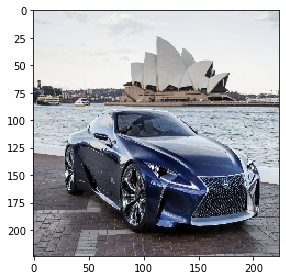

In [5]:
img_path = 'data/MyCar.jpg'
x = get_image(img_path)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=10)[0])

_____
_____
**Self Test: Should we do this Live?**

- A. Yes.
- B. No.
- C. It Depends
- D. We're gonna do it anyway

If you have OpenCV installed, you can try this.

# Imposter Syndrome:

<img src="http://img.memecdn.com/glad-to-know-that-i-amp-039-ve-changed-my-path-years-before_o_7095071.jpg" width=500>


In [6]:
import cv2
import numpy as np
import time
import itertools
%matplotlib inline

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

if 'res_model' not in locals():
    res_model = ResNet50(weights='imagenet')

ESC_KEY = 27

# setup some windows for viewing
cv2.namedWindow("demowin1")
cv2.startWindowThread()

# open the video card for capture
vc = cv2.VideoCapture(0)

if vc.isOpened():  # try to get the first frame
    print ("vc opened, getting first frame")
    rval, frame = vc.read()
    # this will likely fail the first time
    # the webcam often needs some time to open fully
    key = 0
else:
    print ("vc not open, exiting")
    key = ESC_KEY

while key != ESC_KEY and vc.isOpened():  # the escape key and the capture device is open
    rval, frame = vc.read()
    key = cv2.waitKey(10)

    if rval and frame is not None:
        
        frame_to_show = cv2.pyrDown(frame)  # make smaller immediately
        # grab the ROI in top left (will show later on)
        frame_down = frame_to_show[0:224,0:224]
        
        # increase contrast
        img_yuv = cv2.cvtColor(frame_down, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])# equalize the histogram of the Y channel
        frame_down = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)# convert the YUV image back to RGB format

        # and then remove noise
        frame_down = cv2.fastNlMeansDenoisingColored(frame_down,None,7,7,3,11)
        
        img = frame_down.copy() # make a copy for numpy

        x = image.img_to_array(img[:,:,::-1]) # convert to numpy
        x = np.expand_dims(x, axis=0) # add batch dimension
        x = preprocess_input(x) # apply resnet presets

        preds = res_model.predict(x) # get the predictions
        
        # decode the results into a list of tuples (class, description, probability)
        txt = str(decode_predictions(preds, top=3)[0])

        cv2.putText(frame_to_show, txt, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255])
        cv2.rectangle(frame_to_show, (0,0), (224,224), (255,255,255), 1)
        cv2.imshow("demowin1", frame_to_show)
    
print('releasing...')
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
print('Done')

vc opened, getting first frame
releasing...
Done


# Transfer Learning With ResNet

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [2]:
%%time
# from skimage.transform import resize # stupid slow function
from scipy.misc import imresize
import numpy as np

# CIFAR is really small, so let's increase the size of it so its not so small
# once we put it through all the downsampling layers
x_train_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up, axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x, size=(64,64,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up, axis=0)
print(x_test_up.shape)

/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


(50000, 64, 64, 3)


/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


(10000, 64, 64, 3)
CPU times: user 7.59 s, sys: 973 ms, total: 8.57 s
Wall time: 8.68 s


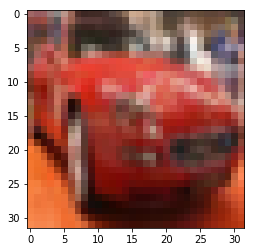

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline
# from skimage.io import imshow
idx = 5
plt.imshow((x_train[idx]-x_train[idx].min())/(x_train[idx].max()-x_train[idx].min()))
plt.grid(False)

In [33]:
x_train_up[0].max()

136.22101

In [3]:
# connect new layers to the output
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = x_train_up[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


CPU times: user 2.88 s, sys: 28.6 ms, total: 2.9 s
Wall time: 1.56 s


(1, 2, 2, 2048)

In [4]:
x_train_up = preprocess_input(x_train_up)
x_test_up = preprocess_input(x_test_up)

In [5]:
%%time

# train on half the data, to save a few hours
x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(50000, 2, 2, 2048)
CPU times: user 1d 4h 52min 22s, sys: 6min 57s, total: 1d 4h 59min 20s
Wall time: 7h 46min 7s


In [6]:
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add, Flatten, Dense
from keras.layers import average, concatenate
from keras.models import Input, Model


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1638600   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
Total params: 1,640,610
Trainable params: 1,640,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
y_train_ohe_resnet = y_train_ohe[:x_train_resnet.shape[0]]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 232s 5ms/step - loss: 1.0178 - acc: 0.7244 - val_loss: 0.7912 - val_acc: 0.7600
Epoch 2/5
50000/50000 [==============================] - 225s 4ms/step - loss: 0.6051 - acc: 0.8122 - val_loss: 0.7327 - val_acc: 0.7786
Epoch 3/5
50000/50000 [==============================] - 220s 4ms/step - loss: 0.4722 - acc: 0.8522 - val_loss: 0.7996 - val_acc: 0.7807
Epoch 4/5
50000/50000 [==============================] - 221s 4ms/step - loss: 0.3650 - acc: 0.8873 - val_loss: 0.9270 - val_acc: 0.7770
Epoch 5/5
50000/50000 [==============================] - 223s 4ms/step - loss: 0.2813 - acc: 0.9145 - val_loss: 1.1049 - val_acc: 0.7830


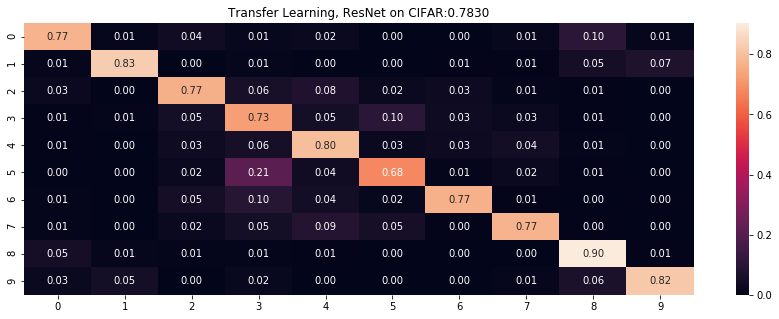

In [10]:
summarize_net(model, x_test_resnet, y_test[:x_test_resnet.shape[0]], title_text='Transfer Learning, ResNet on CIFAR:')

In [11]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 252s 5ms/step - loss: 0.2184 - acc: 0.9357 - val_loss: 1.1913 - val_acc: 0.7839
Epoch 2/5
50000/50000 [==============================] - 259s 5ms/step - loss: 0.1689 - acc: 0.9529 - val_loss: 1.3205 - val_acc: 0.7889
Epoch 3/5
50000/50000 [==============================] - 225s 4ms/step - loss: 0.1373 - acc: 0.9625 - val_loss: 1.5595 - val_acc: 0.7811
Epoch 4/5
50000/50000 [==============================] - 226s 5ms/step - loss: 0.1126 - acc: 0.9692 - val_loss: 1.5395 - val_acc: 0.7917
Epoch 5/5
50000/50000 [==============================] - 228s 5ms/step - loss: 0.0891 - acc: 0.9762 - val_loss: 1.6964 - val_acc: 0.7901


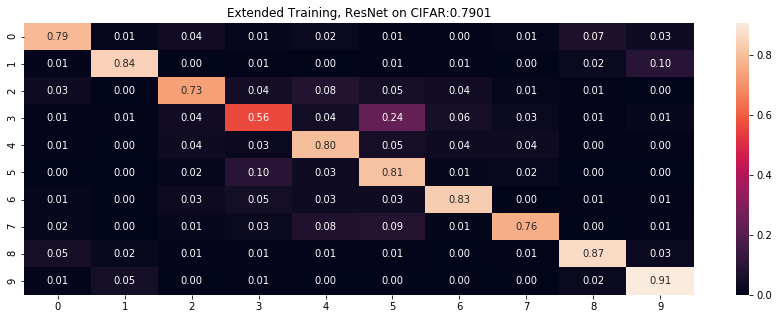

In [12]:
summarize_net(model, x_test_resnet, y_test[:x_test_resnet.shape[0]], title_text='Extended Training, ResNet on CIFAR:')

In [13]:
model.fit(x_train_resnet,y_train_ohe_resnet,epochs=5,
          batch_size=64,verbose=1,
         validation_data=(x_test_resnet, y_test_ohe[:x_test_resnet.shape[0]]))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 224s 4ms/step - loss: 0.0909 - acc: 0.9782 - val_loss: 1.7258 - val_acc: 0.7903
Epoch 2/5
50000/50000 [==============================] - 226s 5ms/step - loss: 0.0769 - acc: 0.9812 - val_loss: 1.7928 - val_acc: 0.7953
Epoch 3/5
50000/50000 [==============================] - 228s 5ms/step - loss: 0.0651 - acc: 0.9852 - val_loss: 1.9714 - val_acc: 0.7861
Epoch 4/5
50000/50000 [==============================] - 223s 4ms/step - loss: 0.0687 - acc: 0.9849 - val_loss: 1.9146 - val_acc: 0.7958
Epoch 5/5
50000/50000 [==============================] - 237s 5ms/step - loss: 0.0589 - acc: 0.9872 - val_loss: 1.9639 - val_acc: 0.7911
